In [1]:
%load_ext autoreload
%autoreload 2

# Running MD using uncertainty as the collective variable

When training a NFF&mdash;either from scratch or using transfer learning from a foundation model&mdash;there may be some regions that are important for your system of interest that are insufficiently sampled. The high uncertainty in these regions can produce poor predictions from the NFF that need to be corrected with additional training data. Our group has pioneered several methods to identify structures with high uncertainty, primarily in the work of Aik Rui Tan on [adversarial attacks](https://www.nature.com/articles/s41467-021-25342-8) and methods of [uncertainty quantification (UQ)](https://www.nature.com/articles/s41524-023-01180-8).

One method that Rui and Johannes Dietschreit developed was using [uncertainty in a model as a collective variable to bias MD simulations](https://pubs.aip.org/aip/jcp/article/162/3/034114/3331444) to generate high-uncertainty structures. This notebook shows how to use some of these tools in the NFF package to run these simulations. The notebook will show:

1. How to fit [Gaussian mixture models (GMM)](https://scikit-learn.org/stable/modules/generated/sklearn.mixture.GaussianMixture.html#gaussianmixture) to an initial dataset and NN Potential to identify regions of high uncertainty
2. How to use the GMM uncertainty and the initial model to run uncertainty-biased MD to generate new structures for active learning

on a small dataset for a simple ammonia molecule. The GMMs are simply Gaussians fit to the embeddings of NFF model that show the latent space that the model has learned the best. By identifying the points in this latent space that have been sampled the most thoroughly, we can identify spaces where the model has higher epistemic uncertainty.

The original paper focuses on a MACE model, but this notebook uses PaiNN. The authors have said that the Gaussian-accelerated MD eABF method is the best option for doing this enhanced sampling. While there are other methods that have calculators available that have been added to the NFF repo (namely, the `AdditiveBias` class), the authors suggest using the GaMD approach because it is fast and reliable.

In [2]:
import os

import matplotlib.pyplot as plt
import nglview as nv
import numpy as np
import torch
from ase import units
from ase.io import read
from ase.optimize import BFGS
from torch.utils.data import DataLoader
from tqdm import tqdm

from nff.data import Dataset, collate_dicts, split_train_validation_test
from nff.io.ase import AtomsBatch
from nff.io.bias_calculators import aMDeABF
from nff.md.colvars import ColVar
from nff.md.nvt import Langevin
from nff.md.utils import BiasedNeuralMDLogger
from nff.train import load_model, loss
from nff.train.evaluate import evaluate
from nff.train.uncertainty import GMMUncertainty, get_unc_class

plt.style.use("default")

/home/ajhoffman/miniforge3/envs/nff/lib/python3.9/site-packages/e3nn/o3/_wigner.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  _Jd, _W3j_flat, _W3j_indices = torch.loa

/home/ajhoffman/NeuralForceField/models


# Fit the Gaussian mixture model

In the first part of the tutorial, we will load a NN model (trained in the notebook `09_painn.ipynb` on a small dataset of DFT data for ethanol molecules) and fit the GMMs to this model and the data on which it's trained. This model will form the basis of the subsequent uncertainty analysis.

## Get the NN model and data

In [3]:
model = load_model("models/cco_painn/best_model")  # a PaiNN model

In [4]:
dataset = Dataset.from_file("data/dataset.pth.tar")
# len(dataset)

In [5]:
# split the dataset
train, val, test = split_train_validation_test(dataset, val_size=0.1, test_size=0.1)
print(f"Train size: {len(train)}, Val size: {len(val)}, Test size: {len(test)}")

Train size: 800, Val size: 100, Test size: 100


In [6]:
train_loader = DataLoader(train, batch_size=32, collate_fn=collate_dicts)
val_loader = DataLoader(val, batch_size=32, collate_fn=collate_dicts)
test_loader = DataLoader(test, batch_size=32, collate_fn=collate_dicts)

In [7]:
loss_fn = loss.build_mse_loss(loss_coef={"energy": 0.1, "energy_grad": 1.0})

## Fitting the GMMs manually

This part of the notebook shows how the GMM is fitted to the embeddings of the model for each of the points in the training data. We use the pooled embeddings (the sum of the node embeddings for each structure) to fit the GMM.

In [ ]:
info_dict = {
    "name": "uncertainty",
    "model_path": "models/cco_painn/best_model",
    "model_type": "Painn",
    "uncertainty_type": "gmm",
    "uncertainty_params": {
        "calibrate": True,
        "cp_alpha": 0.05,
        "n_components": 5,
        "covariance_type": "full",
        "type": "gmm",
        "embedding_kwargs": {
            "n_rff": 1000,
            "learnable": False,
            "n_hidden": 2,
            "n_units": 100,
            "activation": "swish",
            "dropout": 0.0,
        },
    },
    "device": "cpu",
    "batch_size": 32,
    "train_dset": train_loader,
    "calib_dset": val_loader,
    "test_dset": test_loader,
    "loss_fn": loss_fn,
}

In [9]:
train_predicted, _train_targs, _loss = evaluate(
    model=model,
    loader=info_dict["train_dset"],
    loss_fn=info_dict["loss_fn"],
    device=info_dict["device"],
    requires_embedding=True,
    pool_embeddings=True,
)

100%|██████████| 25/25 [00:02<00:00,  8.56it/s]


In [10]:
train_embedding = torch.concat(train_predicted["embedding"])
train_embedding.shape

torch.Size([800, 128])

In [11]:
unc_class = GMMUncertainty(**info_dict["uncertainty_params"])
unc_class.calibrate = True

In [12]:
unc_class.fit_gmm(train_embedding)

The benefit to doing this fitting manually is that we can take the points in the latent space&mdash;both those of the training data and the centers of the GMM&mdash;and plot them to show how they overlap with PCA. Unfortunately, it's a bit tricky to show the variance of the Gaussians with PCA, but we can show the means of each Gaussian.

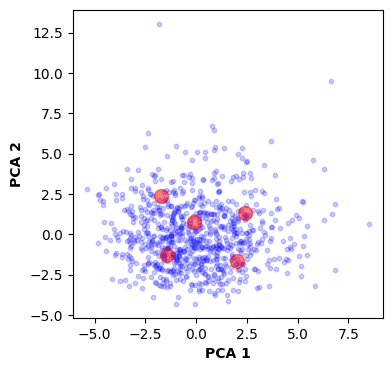

In [13]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca.fit(train_embedding)
pca_embedding = pca.transform(train_embedding)
pca_gmm = pca.transform(unc_class.gm_model.means_)

fig, ax = plt.subplots(figsize=(4, 4))

ax.scatter(pca_embedding[:, 0], pca_embedding[:, 1], c="blue", alpha=0.2, s=10)
ax.scatter(pca_gmm[:, 0], pca_gmm[:, 1], c="red", alpha=0.5, s=100)
ax.set_xlabel("PCA 1", fontweight="bold")
ax.set_ylabel("PCA 2", fontweight="bold")
plt.show()

## Doing it the easy way

The steps above (well, except for the plotting) are all handled by the `get_unc_class` function:

In [32]:
unc = get_unc_class(model, info_dict)

GMM: Doing train prediction


100%|██████████| 25/25 [00:01<00:00, 12.57it/s]


COLVAR: Fitting GMM
COLVAR: Fitting ConformalPrediction


100%|██████████| 4/4 [00:00<00:00, 11.82it/s]


dict_keys(['energy', 'energy_grad', 'features', 'embedding'])
4
torch.Size([288, 128])


ValueError: only one element tensors can be converted to Python scalars

# Running the dynamics

In [16]:
start_geom = val.as_atoms_batches()[0]

100%|██████████| 100/100 [00:00<00:00, 510.82it/s]


In [89]:
test_loader.dataset.props.keys()

dict_keys(['nxyz', 'energy', 'energy_grad', 'smiles', 'num_atoms', 'nbr_list', 'charge', 'spin'])

In [24]:
# central dictionary for the ColVar class
atomlist = list(range(len(start_geom)))
info_dict["index_list"] = atomlist  # want to calculate the CV for all atoms

atoms = AtomsBatch.from_atoms(start_geom, directed=True)

# use the distance of the scan for center of umbrella window
CV = ColVar(info_dict)
cv, cv_grad = CV(atoms)

print(f"Start value: {cv * 180 / np.pi} degrees = {cv} radians")

NameError: name 'start_geom' is not defined

In [65]:
min_val = -20000.0
max_val = 20000.0
dval = 1000.0  # step between minimizations
targets = np.arange(min_val, max_val + dval, dval)
len(targets)

41

In [66]:
cv_info = {
    "barostat_mask": 1,
    "bin_width": 0.1,
    "collect_pot_samples": True,
    "md_ensemble": "nvt",
    "md_ensemble_params": {
        "temperature": 300,
        "timestep": 1.0,
        "friction": 0.1,
    },
    "ext_mass": 50.0,
    "ext_sigma": 0.5,
    "ext_width": 0.5,
    "factor": {
        "ext_mass": 1.0,
        "ext_sigma": 0.9,
        "nsteps": 1.2,
        "sampling_llim": 0.9,
        "time_width": 2.5,
    },
    "nsteps": 100,
    "save_dir": "uncertainty",
    "sampling_method": "latent_embedding",
    "sampling_llim": 0.75,
    "sampling_llim_quantile": 0.75,
    "samd_c0": 0.0001,
    "T_init": 300,
    "unphysical_emax": 10000.0,
    "unphysical_emin": -10000.0,
    "ext_pos": None,
}

In [68]:
device = "cpu"

opt_traj = []
opt_eners = []

for _target in tqdm(targets):
    # this is a list for the class to enable multidimensional PMFs
    # definition is the CV definition
    # as we do a minimization, there is no CV range, we want to set a minimum value
    # ext_k is the force constant in eV/(CV-unit)**2
    cv_defs = [
        {
            "definition": info_dict,
            "range": [min_val, max_val],
            # "ext_k": 100.0,
            "type": "angle",
            **cv_info,
        }
    ]

    # set the calculator, which is the BiasBase class
    calculator = aMDeABF(
        model=model,
        cv_defs=cv_defs,
        dt=0.0002,  # fs
        friction_per_ps=1.0,
        amd_parameter=0.01,
        collect_pot_samples=True,
        estimate_k=True,
        apply_amd=True,
        amd_method="gamd_upper",
        samd_c0=0.0001,
        equil_temp=300,
        nfull=20,
        directed=True,
        device=device,
    )
    atoms.set_calculator(calculator)

    dyn = BFGS(atoms)

    dyn.run(fmax=0.05, steps=20)

    opt_traj.append(atoms.copy())
    opt_eners.append(atoms.get_potential_energy())

opt_eners = np.array(opt_eners)

  0%|          | 0/41 [00:00<?, ?it/s]

COLVAR: Doing train prediction


100%|██████████| 25/25 [00:01<00:00, 14.92it/s]


COLVAR: Fitting GMM


  0%|          | 0/41 [00:03<?, ?it/s]


IndexError: index 991911 is out of bounds for axis 0 with size 400000

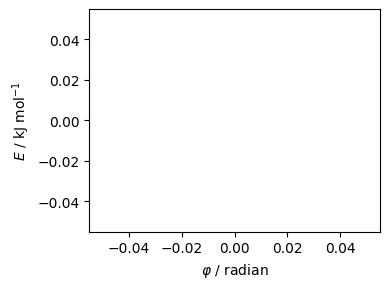

In [56]:
fig, ax = plt.subplots(figsize=(4, 3), layout="tight")

ax.plot(targets, opt_eners * units.mol / units.kJ)

ax.set_xlabel(r"$\varphi$ / radian")
ax.set_ylabel(r"$E$ / kJ mol$^{-1}$")

fig.show()

In [61]:
from ase.io import Trajectory, write
import tempfile

tmpfile_path = "bias_traj.xyz"
with open(tmpfile_path, "w") as tmpfile:
    write(tmpfile, opt_traj, format="xyz")

# traj = Trajectory(tmpfile_path)
# nv.show_asetraj(traj)
view = nv.show_file(tmpfile_path)
view.add_representation("ball+stick")
view

NGLWidget()

# Another approach

These tools also work with the MACE architecture. Since you are intentionally biasing the MD sampling to regions that have high uncertainty, it may be wise to use a foundation model&mdash;a potential that is pre-trained on a large dataset like [MPTraj]()&mdash;rather than, say, a potential that you are training from scratch and that might be more unstable and fail in these high uncertainty regions. The advantage to using a model like `PaiNN` is that it's very fast; `MACE-MP-0` is very stable, but training it and using it for inference can be very slow. This is not to dissuade you from using one over the other, but using `MACE-MP-0` for sampling and training `PaiNN` from scratch may be a very efficient way to create a potential for your task.